In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from time import sleep
from IPython.display import clear_output

from collections import namedtuple, deque
from unityagents import UnityEnvironment

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [3]:
import warnings
warnings.simplefilter('ignore', UserWarning)

In [4]:
plt.style.use('ggplot')

## Set Configs

In [5]:
is_cuda = torch.cuda.is_available()

if is_cuda: device = torch.device('cuda')
else: device = torch.device('cpu')

In [6]:
BUFFER_SIZE = int(1e5)
BATCH_SIZE = 64
GAMMA = 0.99
TAU = 1e-3 # for soft update of target parameters
LR = 5e-4
PRINT_EVERY = 100
UPDATE_EVERY = 4

SEED = 90

## Set Environment

In [7]:
env = UnityEnvironment(file_name='./Banana.app')

brain_name = env.brain_names[0] # get the brain from unity environment
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [8]:
print('Environment Info')
env_info = env.reset(train_mode=False)[brain_name] # reset environment to a new, random state
state = env_info.vector_observations[0]
action_size = brain.vector_action_space_size

print('Number of agents: {}'.format(len(env_info.agents)))
print('State space: {}'.format(len(state)))
print('Action space: {}'.format(action_size))

Environment Info
Number of agents: 1
State space: 37
Action space: 4


## 🎬 Watch The Agent

In [9]:
total_score = []
num_episodes = 20

for i in range(1, num_episodes+1):
    
    score = 0
    print(f'Watching episode {i}...', end='')
    
    while True:
        
        action = np.random.randint(action_size)
        env_info = env.step(action)[brain_name]
        next_state = env_info.vector_observations[0]
        reward = env_info.rewards[0]
        done = env_info.local_done[0]
        score += reward
        state = next_state
        
        if done:
            clear_output(wait=True)
            
            total_score.append(score)
            env.reset()
            break
            
print('Watching finished.')
print('Average score for {} episodes: {}'.format(num_episodes, np.mean(total_score)))

Watching finished.
Average score for 20 episodes: -0.3


## Build DQN Architecture

In [10]:
class DQN(nn.Module):
    """Define DQN architecture."""
    
    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):
        
        super(DQN, self).__init__()
        
        self.seed = torch.manual_seed(seed)
        
        self.fc1_layer = nn.Linear(state_size, fc1_units)
        self.fc2_layer = nn.Linear(fc1_units, fc2_units)
        self.fc3_layer = nn.Linear(fc2_units, action_size)
        
    def forward(self, state):
        """Build a network that maps state into action values."""
        
        x = F.relu(self.fc1_layer(state))
        x = F.relu(self.fc2_layer(x))
        Qsa = self.fc3_layer(x)
        
        return Qsa

## Set Replay Buffer

In [11]:
class ReplayBuffer(object):
    """Fixed-size buffer to store experience tuples."""
    
    def __init__(self, buffer_size, batch_size, seed):
        """Initialize a ReplayMemory object."""
        
        self.experience = namedtuple('Experience', field_names=['state', 'action', 'reward', 'next_state', 'done'])
        self.seed = random.seed(seed)
        
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to buffer."""
        self.memory.append(self.experience(state, action, reward, next_state, done))
    
    def sample(self):
        """Add a new experience to buffer."""
        
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states = torch.from_numpy(np.vstack([exp.state for exp in experiences if exp is not None])).float()
        states = states.to(device)
        
        actions = torch.from_numpy(np.vstack([exp.action for exp in experiences if exp is not None])).long()
        actions = actions.to(device)
        
        rewards = torch.from_numpy(np.vstack([exp.reward for exp in experiences if exp is not None])).float()
        rewards = rewards.to(device)
        
        next_states = torch.from_numpy(np.vstack([exp.next_state for exp in experiences if exp is not None])).float()
        next_states = next_states.to(device)
        
        dones = torch.from_numpy(np.vstack([exp.done for exp in experiences if exp is not None]).astype(np.uint8)).float()
        dones = dones.to(device)
        
        return (states, actions, rewards, next_states, dones)
    
    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

## Define Double DQN Agent

In [12]:
class Double_DQNAgent(object):
    """The agent interacting with and learning from the environment."""
    
    def __init__(self, state_size, action_size, seed):
        """Initialize an agent object."""
        
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        
        # init Q-Network & target network
        self.dqn_net = DQN(state_size, action_size, seed).to(device)
        self.target_net = DQN(state_size, action_size, seed).to(device)
        
        # init optimizer
        self.optimizer = optim.Adam(self.dqn_net.parameters(), lr=LR)
        
        # init Replay Buffer
        self.buffer = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE, seed)
        self.time_step = 0
    
    def memorize(self, state, action, reward, next_state, done):
        """Save experience in replay buffer."""
        
        self.buffer.add(state, action, reward, next_state, done)
        
        self.time_step = (self.time_step + 1) % UPDATE_EVERY
        if self.time_step == 0:
            # if enough samples are available in memory, get random subset and learn
            if len(self.buffer) > BATCH_SIZE:
                experiences = self.buffer.sample()
                self.learn(experiences, GAMMA)
        
    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples."""
        
        states, actions, rewards, next_states, dones = experiences
        
        self.optimizer.zero_grad()
        
        # get index of maximum value for next state
        Qsa_next = self.dqn_net(next_states).detach()
        _, action_max = Qsa_next.max(1)
        
        # get max predicted Q values (for next states) from target network
        Qsa_next = self.target_net(next_states).detach().gather(1, action_max.unsqueeze(1))
        
        # compute Q target
        Q_target = rewards + (gamma * Qsa_next * (1 - dones))
        
        # get expected Q values from dqn network
        Q_expected = self.dqn_net(states).gather(1, actions)
        
        # compute loss
        loss = F.mse_loss(Q_expected, Q_target)
        
        # minimize the loss
        loss.backward()
        self.optimizer.step()
        
        # update target network
        self.soft_update(self.dqn_net, self.target_net, TAU)
        
    def soft_update(self, dqn_net, target_net, tau):
        """Soft update target network parameters."""
        
        for dqn_param, target_param in zip(dqn_net.parameters(), target_net.parameters()):
            target_param.data.copy_(tau*dqn_param.data + (1.0-tau) * target_param.data)
    
    def act(self, state, eps=0.):
        """Return actions for given state as per current policy."""
        
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        
        self.dqn_net.eval()
        with torch.no_grad():
            action_values = self.dqn_net(state)
            
        self.dqn_net.train()
        
        # epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
    
    def save(self, agent_location):
        torch.save(self.dqn_net.state_dict(), agent_location)
    
    def load(self, agent_location):
        self.dqn_net.load_state_dict(torch.load(agent_location))

In [13]:
agent = Double_DQNAgent(state_size=len(state), action_size=action_size, seed=SEED)

## Train The Agent

In [14]:
def train_agent(num_episodes, max_time=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Train DQN agent."""
    
    scores = []
    scores_target = 13.0
    scores_window = deque(maxlen=100)
    eps = eps_start
    
    for i_episode in range(1, num_episodes+1):
        
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for time_step in range(max_time):
            
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]
            next_state, reward, done = env_info.vector_observations[0], env_info.rewards[0], env_info.local_done[0]
            
            agent.memorize(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
                
        scores_window.append(score)
        scores.append(score)
        eps = max(eps_end, eps_decay*eps)
        
        print(f'\rEpisode: {i_episode}, Average Score: {np.mean(scores_window):.2f}', end='')
        
        if i_episode % PRINT_EVERY == 0:
            print(f'\rEpisode: {i_episode}, Average Score: {np.mean(scores_window):.2f}')
        if np.mean(scores_window) >= scores_target:
            print(f'\nEnvironment solved in {i_episode-100:d} episodes! Average Score: {np.mean(scores_window):.2f}')
            if not os.path.exists('./agents/'): os.makedirs('./agents/')
            agent.save(f'./agents/Double_DQN_{brain_name}.pth')
            
    print('Training completed.')
    return scores

In [15]:
scores = train_agent(num_episodes=1000, max_time=1000)

Episode: 100, Average Score: 1.26
Episode: 200, Average Score: 4.71
Episode: 300, Average Score: 8.56
Episode: 400, Average Score: 10.56
Episode: 500, Average Score: 12.24
Episode: 528, Average Score: 13.01
Environment solved in 428 episodes! Average Score: 13.01
Episode: 529, Average Score: 13.05
Environment solved in 429 episodes! Average Score: 13.05
Episode: 530, Average Score: 13.16
Environment solved in 430 episodes! Average Score: 13.16
Episode: 531, Average Score: 13.15
Environment solved in 431 episodes! Average Score: 13.15
Episode: 532, Average Score: 13.22
Environment solved in 432 episodes! Average Score: 13.22
Episode: 533, Average Score: 13.18
Environment solved in 433 episodes! Average Score: 13.18
Episode: 534, Average Score: 13.23
Environment solved in 434 episodes! Average Score: 13.23
Episode: 535, Average Score: 13.37
Environment solved in 435 episodes! Average Score: 13.37
Episode: 536, Average Score: 13.39
Environment solved in 436 episodes! Average Score: 13.39


Episode: 616, Average Score: 15.54
Environment solved in 516 episodes! Average Score: 15.54
Episode: 617, Average Score: 15.60
Environment solved in 517 episodes! Average Score: 15.60
Episode: 618, Average Score: 15.57
Environment solved in 518 episodes! Average Score: 15.57
Episode: 619, Average Score: 15.62
Environment solved in 519 episodes! Average Score: 15.62
Episode: 620, Average Score: 15.54
Environment solved in 520 episodes! Average Score: 15.54
Episode: 621, Average Score: 15.55
Environment solved in 521 episodes! Average Score: 15.55
Episode: 622, Average Score: 15.51
Environment solved in 522 episodes! Average Score: 15.51
Episode: 623, Average Score: 15.42
Environment solved in 523 episodes! Average Score: 15.42
Episode: 624, Average Score: 15.43
Environment solved in 524 episodes! Average Score: 15.43
Episode: 625, Average Score: 15.38
Environment solved in 525 episodes! Average Score: 15.38
Episode: 626, Average Score: 15.39
Environment solved in 526 episodes! Average S

Episode: 706, Average Score: 15.81
Environment solved in 606 episodes! Average Score: 15.81
Episode: 707, Average Score: 15.74
Environment solved in 607 episodes! Average Score: 15.74
Episode: 708, Average Score: 15.73
Environment solved in 608 episodes! Average Score: 15.73
Episode: 709, Average Score: 15.66
Environment solved in 609 episodes! Average Score: 15.66
Episode: 710, Average Score: 15.67
Environment solved in 610 episodes! Average Score: 15.67
Episode: 711, Average Score: 15.63
Environment solved in 611 episodes! Average Score: 15.63
Episode: 712, Average Score: 15.60
Environment solved in 612 episodes! Average Score: 15.60
Episode: 713, Average Score: 15.53
Environment solved in 613 episodes! Average Score: 15.53
Episode: 714, Average Score: 15.52
Environment solved in 614 episodes! Average Score: 15.52
Episode: 715, Average Score: 15.54
Environment solved in 615 episodes! Average Score: 15.54
Episode: 716, Average Score: 15.54
Environment solved in 616 episodes! Average S

Episode: 796, Average Score: 15.42
Environment solved in 696 episodes! Average Score: 15.42
Episode: 797, Average Score: 15.44
Environment solved in 697 episodes! Average Score: 15.44
Episode: 798, Average Score: 15.46
Environment solved in 698 episodes! Average Score: 15.46
Episode: 799, Average Score: 15.43
Environment solved in 699 episodes! Average Score: 15.43
Episode: 800, Average Score: 15.47

Environment solved in 700 episodes! Average Score: 15.47
Episode: 801, Average Score: 15.44
Environment solved in 701 episodes! Average Score: 15.44
Episode: 802, Average Score: 15.55
Environment solved in 702 episodes! Average Score: 15.55
Episode: 803, Average Score: 15.60
Environment solved in 703 episodes! Average Score: 15.60
Episode: 804, Average Score: 15.61
Environment solved in 704 episodes! Average Score: 15.61
Episode: 805, Average Score: 15.61
Environment solved in 705 episodes! Average Score: 15.61
Episode: 806, Average Score: 15.59
Environment solved in 706 episodes! Average 

Episode: 886, Average Score: 15.67
Environment solved in 786 episodes! Average Score: 15.67
Episode: 887, Average Score: 15.68
Environment solved in 787 episodes! Average Score: 15.68
Episode: 888, Average Score: 15.67
Environment solved in 788 episodes! Average Score: 15.67
Episode: 889, Average Score: 15.63
Environment solved in 789 episodes! Average Score: 15.63
Episode: 890, Average Score: 15.63
Environment solved in 790 episodes! Average Score: 15.63
Episode: 891, Average Score: 15.74
Environment solved in 791 episodes! Average Score: 15.74
Episode: 892, Average Score: 15.73
Environment solved in 792 episodes! Average Score: 15.73
Episode: 893, Average Score: 15.75
Environment solved in 793 episodes! Average Score: 15.75
Episode: 894, Average Score: 15.75
Environment solved in 794 episodes! Average Score: 15.75
Episode: 895, Average Score: 15.85
Environment solved in 795 episodes! Average Score: 15.85
Episode: 896, Average Score: 15.84
Environment solved in 796 episodes! Average S

Episode: 976, Average Score: 15.84
Environment solved in 876 episodes! Average Score: 15.84
Episode: 977, Average Score: 15.75
Environment solved in 877 episodes! Average Score: 15.75
Episode: 978, Average Score: 15.81
Environment solved in 878 episodes! Average Score: 15.81
Episode: 979, Average Score: 15.85
Environment solved in 879 episodes! Average Score: 15.85
Episode: 980, Average Score: 15.79
Environment solved in 880 episodes! Average Score: 15.79
Episode: 981, Average Score: 15.83
Environment solved in 881 episodes! Average Score: 15.83
Episode: 982, Average Score: 15.86
Environment solved in 882 episodes! Average Score: 15.86
Episode: 983, Average Score: 15.84
Environment solved in 883 episodes! Average Score: 15.84
Episode: 984, Average Score: 15.80
Environment solved in 884 episodes! Average Score: 15.80
Episode: 985, Average Score: 15.81
Environment solved in 885 episodes! Average Score: 15.81
Episode: 986, Average Score: 15.82
Environment solved in 886 episodes! Average S

## Evaluate The Agent

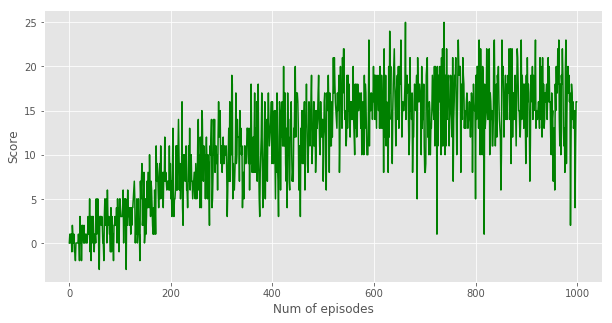

In [16]:
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(scores)), scores, color='green')
plt.xlabel('Num of episodes')
plt.ylabel('Score')
if not os.path.exists('./images/'): os.makedirs('./images/')
plt.savefig('./images/plot_of_double_dqn_agent_evaluation.png')
plt.show()

## 🎬 Watch The Smart Agent

In [17]:
agent.load(f'./agents/Double_DQN_{brain_name}.pth')

In [18]:
num_episodes = 5
max_time=1000

scores = []

for i in range(1, num_episodes+1):
    
    print(f'Watching episode {i}...', end='')
    
    env_info = env.reset(train_mode=False)[brain_name]
    state = env_info.vector_observations[0]
    score = 0    
    for time_step in range(max_time):
                
        action = agent.act(state)
        env_info = env.step(action)[brain_name]
        next_state, reward, done = env_info.vector_observations[0], env_info.rewards[0], env_info.local_done[0]
            
        state = next_state
        score += reward
        if done:
            clear_output(wait=True)

            env.reset()
            break
            
    scores.append(score)

print('Watching finished.')
print('Total score for {} episodes: {}'.format(num_episodes, np.mean(scores)))

Watching finished.
Total score for 5 episodes: 17.8


---